In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# Load data
accel_one = pd.read_csv("IDNet_dataset/u001_w001/u001_w001_accelerometer.log", sep='\s+')  
accel_one.columns = ["a_time", "a_x", "a_y", "a_z"]
accel_one.head()


,a_time,a_x,a_y,a_z
0,924312945848402,0.990402,5.696289,8.426147
1,924312954240736,1.021072,5.682388,8.617645
2,924312962633070,0.866730,5.670349,8.578476
3,924312971025404,0.681320,5.633255,8.295212
4,924312979417738,0.474564,5.593475,7.818085


In [3]:
# Low pass filter
plt.close()
# Code from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, sample_freq, order=5):
    nyq = 0.5 * sample_freq 
    normal_cutoff = cutoff / nyq #converts from frequency to cycles per half sample
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def get_sample_freq(time_stamps):
    nano = time_stamps[1] - time_stamps[0]
    seconds = nano/1e9
    return 1/seconds
    

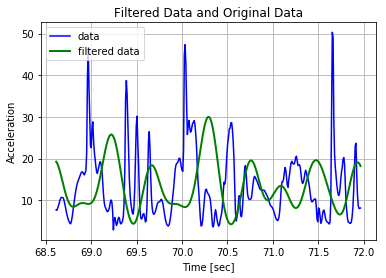

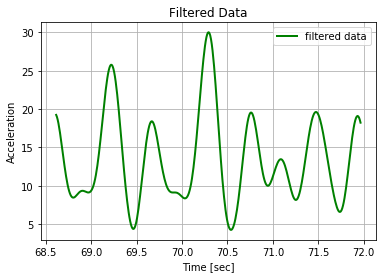

In [4]:
# Make vector with magnitude of accelerations for each data point
accel_mag = np.linalg.norm(accel_one[["a_x","a_y", "a_z"]].values, axis = 1)

# Filter requirements.
order = 6
fs = get_sample_freq(accel_one["a_time"].values)  # sample rate, Hz
cutoff = 3  # desired cutoff frequency of the filter, Hz

# Time stamps in seconds
t = accel_one["a_time"].values/1e9 - accel_one["a_time"][0]/1e9

# "Noisy" data.
data = accel_mag

# Filter the data, and plot both the original and filtered signals.
filtered_data = butter_lowpass_filter(data, cutoff, fs, order)

# Plot Filtered and Original Data
upper = 8376-200
lower = 8376+200
plt.plot(t[upper:lower], data[upper:lower], 'b-', label='data')
plt.plot(t[upper:lower], filtered_data[upper:lower], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.title('Filtered Data and Original Data')
plt.ylabel("Acceleration")
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)
plt.savefig("original_and_filtered.png")
plt.show()

# Plot Filtered Data
plt.figure()
plt.plot(t[upper:lower], filtered_data[upper:lower], 'g-', linewidth=2, label='filtered data')
plt.legend()
plt.grid()
plt.title('Filtered Data')
plt.xlabel('Time [sec]')
plt.ylabel("Acceleration")
plt.savefig("filtered.png")
plt.show()


In [5]:
# Finding i*

# Finding the correlation distance; smaller number means more similar
def corr_dist(u, v):
    centered_u = u - np.mean(u)
    centered_v = v - np.mean(v)
    return 1 - centered_u.T@centered_v/(np.linalg.norm(centered_u)*np.linalg.norm(centered_v))
    

# Global max of filtered data 
# Note: different from paper because min gives zero
i_tilde = np.argmax(filtered_data)
print(i_tilde)

# Max within 10 observations of i_tilde of unfiltered data
i_star = np.argmax(accel_mag[i_tilde-10:i_tilde+10]) - 10 + i_tilde

# Finding template
# Acceleration within a half second on either side of i_star
template_size =2*np.floor(fs*0.5).astype(int)
template = accel_mag[i_star - template_size//2 : i_star + template_size//2]

8376
8314


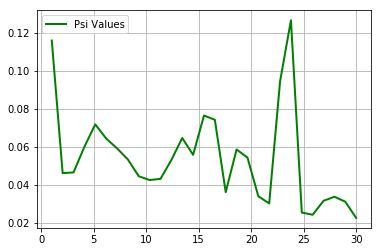

In [17]:
# Find psi(i)

template_updates = 30
psi_threshold = 0.4
window_size = template_size + 500
i_min = 0
i_max = window_size
alpha = 0.9 #this probably needs to change
psi_min_vals = []

j = 0

plt.close()

# Plot original template
# t = np.linspace(0, template_size, template_size)
# plt.plot(t, template, 'g-', linewidth=2, label='Template')
# plt.show()

while j < template_updates:
    
    # Make sure we don't index out of range
    if i_max > accel_mag.shape[0]:
        break
    
    # Update psi values for current template
    psi_vals = np.zeros(window_size)
    for i in range(i_min, i_max):
        psi_vals[i - i_min] = corr_dist(template, accel_mag[i:i+template_size])
   
    # Plot psi_vals
    # psi_t = np.linspace(i_min, i_max, i_max-i_min)
    # plt.figure()
    # plt.plot(psi_t, psi_vals, 'p-')
    
    # Find first psi value below psi_threshold between i_min and i_max
    psi_min = np.argmin(psi_vals)

    
    t_prime = accel_mag[i_min+psi_min:i_min + psi_min + template_size]
    if psi_vals[psi_min] < psi_threshold:
        template = template*alpha + (1 - alpha)*t_prime
        j += 1
        psi_min_vals.append(psi_vals[psi_min])
        # Plot progress of template
        # plt.plot(t, template, 'b-', linewidth=2, label='Template')
        # plt.plot(t, t_prime, 'r-', linewidth=2)
        # plt.show()
      
    i_min += window_size
    i_max += window_size
    
    
#print(psi_min_vals)
lower = 250
upper = 750
t = np.linspace(1, len(psi_min_vals), len(psi_min_vals)-1)
plt.close()
plt.plot(t, psi_min_vals[1:], 'g-', linewidth=2, label='Psi Values')
plt.legend()
plt.grid()
plt.show()


